In this notebook we'll solve the Bernoulli Bandits problem using the QCLP formulation presented in the paper below:
https://www.ijcai.org/Proceedings/07/Papers/389.pdf

I'll also be borrowing from this video and the code presented in it:
https://www.youtube.com/watch?v=8GuQAfyvWYc&list=PLRwcSE2bmyBxc9u_tV65sZTGy729nqgiv&index=16&ab_channel=ICTPQuantitativeLifeSciences

In [365]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from QCLP formulation.py import qclp_formulation

SyntaxError: invalid syntax (3144140387.py, line 7)

# Two-armed Bernoulli Bandits...

* Credits: Andrea Mazzolini, Alberto Pezzotta*

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="400">
</div>

In the most general case, there is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="400">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll choose to focus on two symmetric states (A,B) of this square where we have the following probabilities:
* Probability of winning in state A having chosen action (arm) 1: $P(r = 1 \,|\, s= A, a=1) = \theta$ 
* Probability of winning in state A having chosen action (arm) 2: $P(r = 1 \,|\, s= A, a=2) = 1 - \theta$ 
* Probability of winning in state B having chosen action (arm) 1: $P(r = 1 \,|\, s= B, a=1) = 1 - \theta$ 
* Probability of winning in state B having chosen action (arm) 2: $P(r = 1 \,|\, s= B, a=2) = \theta$ 

Upon choosing $\theta$ we get the two states:

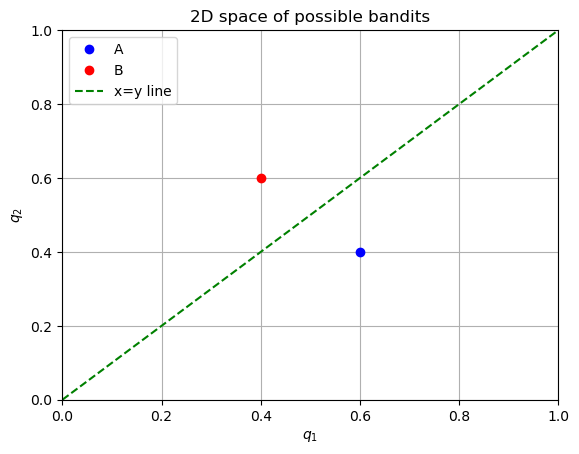

In [339]:
theta = 0.6
# Define the coordinates of the two points
point1 = (theta, 1- theta)
point2 = (1- theta, theta)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# Show plot
plt.show()


Following this we define our POMDP parameter values

In [340]:
#Define POMDP parameters

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

b0 = np.ones((num_states)) / num_states # uniform initial distribution over states
gamma = 0.5 # Discount factor 
theta = 0.8 # Bernoulli parameter for the reward

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = theta, 1 - theta
# state B
reward_model[1, 0], reward_model[1, 1] = 1 - theta, theta

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
for state, action, observation in product(s,a,o):
    if state == action:
        observation_model[state,action,observation] = bernoulliprob(theta, observation)
    else:
        observation_model[state,action,observation] = bernoulliprob(1-theta, observation)


Visualizing POMDP parameter values

In [341]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df.rename_axis("(s',a,s)", axis="columns").T

,Transition probability
"(s',a,s)",
"('A', 1, 'A')",1.0
"('A', 1, 'B')",0.0
"('A', 2, 'A')",1.0
"('A', 2, 'B')",0.0
"('B', 1, 'A')",0.0
"('B', 1, 'B')",1.0
"('B', 2, 'A')",0.0
"('B', 2, 'B')",1.0


In [342]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.8,0.2
B,0.2,0.8


In [343]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability']).T
observation_model_df.rename_axis("(s',a,o)", axis="index")

,Observation probability
"(s',a,o)",
"('A', 1, 0)",0.2
"('A', 1, 1)",0.8
"('A', 2, 0)",0.8
"('A', 2, 1)",0.2
"('B', 1, 0)",0.8
"('B', 1, 1)",0.2
"('B', 2, 0)",0.2
"('B', 2, 1)",0.8


FSC

In [344]:
num_nodes = 5
q = list(range(num_nodes)) # Nodes in the FSC
q

[0, 1, 2, 3, 4]

# QCLP formulation
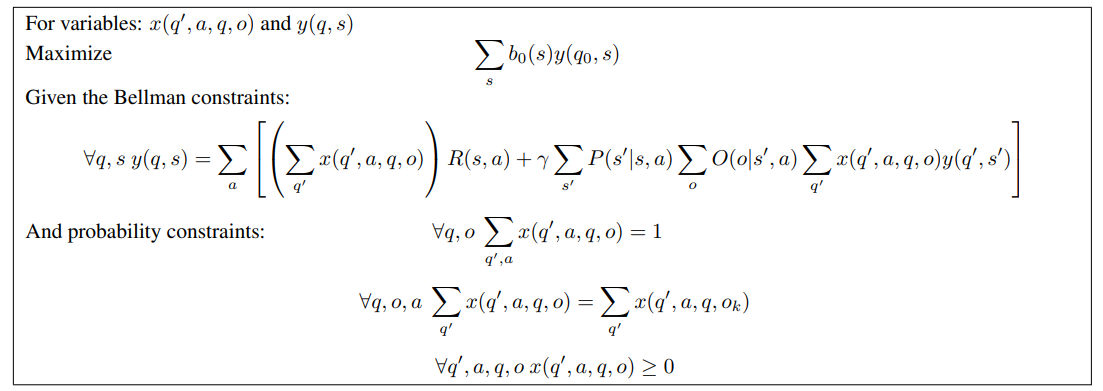

Where the variable $x(q', a, q, o)$ represents $P(q', a|q, o)$, variable $y(q, s)$
represents $V(q, s)$, $q_0$ is the initial controller node and $o_k$ is an arbitrary fixed observation

Note that $P(q', a|q, o)= P(q'|q, o) P(a|q)$ 

And $\sum{q'} P(q', a|q, o) = P(a|q)$

In [345]:
model = ConcreteModel()


# model.q = RangeSet(0,len(q)-1)
# model.a = RangeSet(0,len(a)-1)
# model.o = RangeSet(0,len(o)-1)
# model.s = RangeSet(0,len(s)-1)
model.q = range(num_nodes)
model.a = range(num_actions)
model.o = range(num_observations)
model.s = range(num_states)

# Variables
## x(q', a, q, o) = P(q', a | q, o)
model.x = Var(model.q,model.a,model.q,model.o, bounds = (0.0,1.0))

## y(q, s) = V(q , s)
model.y = Var(model.q,model.s )

# Objective
q0 = 0
model.Obj = Objective(expr = sum([b0[s_]*model.y[q0,s_] for s_ in s]) , sense = maximize)


# Constraints
## Probability constraints
model.sum_over_action_and_qp = ConstraintList()
for q_,o_ in product(q,o):
    model.sum_over_action_and_qp.add(sum([model.x[qp_,a_,q_,o_] for qp_,a_ in product(q,a)]) == 1) 


model.sum_independence_on_o = ConstraintList()
for q_, o_, a_ in product(q, o, a):
    model.sum_independence_on_o.add(sum([model.x[qp_, a_, q_, o_] for qp_ in q]) == sum([model.x[qp_, a_, q_, 0] for qp_ in q])) 

## Bellman equation constraints
model.bellman_equation = ConstraintList()
for q_, s_ in product(q, s):
    model.bellman_equation.add( model.y[q_, s_] == sum([ 
                ### The 0 in this line should be o_, but the constraint means we can keep it as 0
                sum([model.x[qp_, a_, q_, 0]  for qp_ in q]) * \
                reward_model[s_, a_] + \
                gamma * sum([
                    state_transition_model[s_, a_, sp_] *  \
                    sum([
                        observation_model[sp_, a_, o_] * \
                            sum([model.x[qp_, a_, q_, o_] * model.y[qp_, sp_] for qp_ in q])            
                        for o_ in o
                    ])
                    for sp_ in s
                ]) 
                for a_ in a
            ])) 


In [346]:
opt = SolverFactory('ipopt')
res = opt.solve(model) 
print(res.write())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 40
  Number of variables: 110
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.5728592872619629
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
None


In [347]:
print(model.y.display())

y : Size=10, Index=y_index
    Key    : Lower : Value              : Upper : Fixed : Stale : Domain
    (0, 0) :  None : 0.9999999999999979 :  None : False : False :  Reals
    (0, 1) :  None : 0.9999999999999978 :  None : False : False :  Reals
    (1, 0) :  None : 0.9999999999999973 :  None : False : False :  Reals
    (1, 1) :  None : 0.9999999999999982 :  None : False : False :  Reals
    (2, 0) :  None : 0.9999999999999963 :  None : False : False :  Reals
    (2, 1) :  None : 0.9999999999999996 :  None : False : False :  Reals
    (3, 0) :  None : 0.9999999999999974 :  None : False : False :  Reals
    (3, 1) :  None : 0.9999999999999983 :  None : False : False :  Reals
    (4, 0) :  None : 0.9999999999999982 :  None : False : False :  Reals
    (4, 1) :  None : 0.9999999999999973 :  None : False : False :  Reals
None


In [348]:
print(model.x.display())

x : Size=100, Index=x_index
    Key          : Lower : Value               : Upper : Fixed : Stale : Domain
    (0, 0, 0, 0) :   0.0 :  0.1000000002624362 :   1.0 : False : False :  Reals
    (0, 0, 0, 1) :   0.0 : 0.10000000026243687 :   1.0 : False : False :  Reals
    (0, 0, 1, 0) :   0.0 : 0.10000000009108578 :   1.0 : False : False :  Reals
    (0, 0, 1, 1) :   0.0 :  0.1000000000910856 :   1.0 : False : False :  Reals
    (0, 0, 2, 0) :   0.0 : 0.10000000009108594 :   1.0 : False : False :  Reals
    (0, 0, 2, 1) :   0.0 : 0.10000000009108506 :   1.0 : False : False :  Reals
    (0, 0, 3, 0) :   0.0 : 0.10000000009108521 :   1.0 : False : False :  Reals
    (0, 0, 3, 1) :   0.0 : 0.10000000009108577 :   1.0 : False : False :  Reals
    (0, 0, 4, 0) :   0.0 :  0.1000000000910866 :   1.0 : False : False :  Reals
    (0, 0, 4, 1) :   0.0 : 0.10000000009108623 :   1.0 : False : False :  Reals
    (0, 1, 0, 0) :   0.0 : 0.10000000026243669 :   1.0 : False : False :  Reals
    (0, 1, 0

In [349]:
print(model.Obj.display())

Obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 0.9999999999999978
None


look for ipopt parameters

In [350]:
print(set([1,2,(3)]))

{1, 2, 3}


In [351]:
model.IDX = Set( initialize=range(5) )
model.a = Var( model.IDX )
model.b = Var()
def c4_rule(model, i):
    return model.a[i] + model.b <= 1
model.c4 = Constraint( model.IDX, rule=c4_rule )
model.c4.pprint()

with a new Component with type <class 'pyomo.core.base.var.IndexedVar'>. This
is usually indicative of a modelling error. To avoid this warning, explicitly
delete the attribute:
        del unknown.a
c4 : Size=5, Index=IDX, Active=True
    Key : Lower : Body     : Upper : Active
      0 :  -Inf : a[0] + b :   1.0 :   True
      1 :  -Inf : a[1] + b :   1.0 :   True
      2 :  -Inf : a[2] + b :   1.0 :   True
      3 :  -Inf : a[3] + b :   1.0 :   True
      4 :  -Inf : a[4] + b :   1.0 :   True


In [353]:
model.idxtwo  = model.IDX *  model.IDX
model.b = Var( model.idxtwo )
model.b.pprint()

(model).unknown with a new Component with type <class
'pyomo.core.base.set.SetProduct_OrderedSet'>. This is usually indicative of a
modelling error. To avoid this warning, explicitly delete the attribute:
        del unknown.idxtwo
'pyomo.core.base.var.ScalarVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
b : Size=25, Index=idxtwo
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (0, 0) :  None :  None :  None : False :  True :  Reals
    (0, 1) :  None :  None :  None : False :  True :  Reals
    (0, 2) :  None :  None :  None : False :  True :  Reals
    (0, 3) :  None :  None :  None : False :  True :  Reals
    (0, 4) :  None :  None :  None : False :  True :  Reals
    (1, 0) :  None :  None :  None : False :  True :  Reals
    (1, 1) :  None :  None :  None : False :  True :  Reals
    (1, 2) :  No

![QCLP formulation.png](<attachment:QCLP formulation.png>)
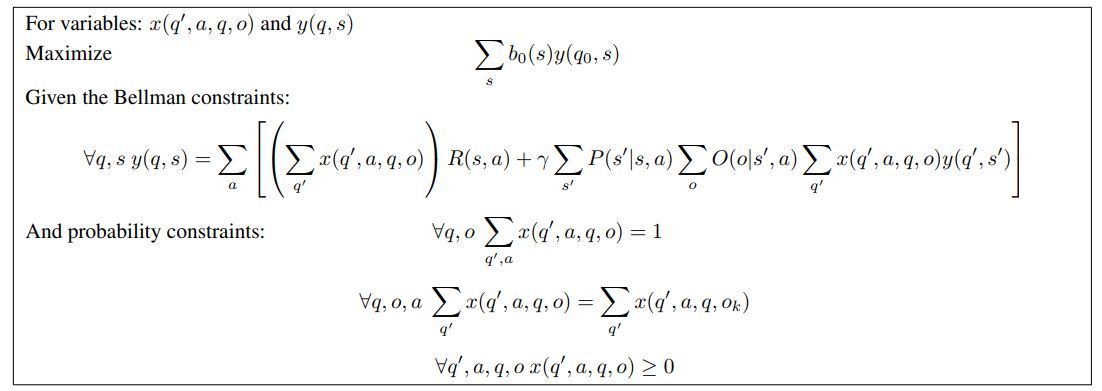

In [355]:
newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)

In [359]:
opt = SolverFactory('ipopt')
res = opt.solve(newmodel) 
print(res.write())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 40
  Number of variables: 110
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.08344483375549316
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
None


In [363]:
newmodel.x.display()

x : Size=100, Index=x_index
    Key          : Lower : Value               : Upper : Fixed : Stale : Domain
    (0, 0, 0, 0) :   0.0 :  0.1000000002624365 :   1.0 : False : False :  Reals
    (0, 0, 0, 1) :   0.0 : 0.10000000026243717 :   1.0 : False : False :  Reals
    (0, 0, 1, 0) :   0.0 : 0.10000000009108581 :   1.0 : False : False :  Reals
    (0, 0, 1, 1) :   0.0 : 0.10000000009108556 :   1.0 : False : False :  Reals
    (0, 0, 2, 0) :   0.0 : 0.10000000009108591 :   1.0 : False : False :  Reals
    (0, 0, 2, 1) :   0.0 : 0.10000000009108503 :   1.0 : False : False :  Reals
    (0, 0, 3, 0) :   0.0 : 0.10000000009108519 :   1.0 : False : False :  Reals
    (0, 0, 3, 1) :   0.0 : 0.10000000009108577 :   1.0 : False : False :  Reals
    (0, 0, 4, 0) :   0.0 : 0.10000000009108667 :   1.0 : False : False :  Reals
    (0, 0, 4, 1) :   0.0 : 0.10000000009108621 :   1.0 : False : False :  Reals
    (0, 1, 0, 0) :   0.0 : 0.10000000026243722 :   1.0 : False : False :  Reals
    (0, 1, 0